Author: Arend-Jan Quist\
Date of creation: 6 May 2020\
Last modified: 15 June 2020

Create a artificially created dataset of a moire lattice with Gaussian peaks.\
Apply drizzle and shift-and-add to this dataset. \
Apply various types of data processing to these images.

In [4]:
import numpy as np
from scipy import ndimage
from skimage import data, io, filters
import matplotlib.pyplot as plt

from Drizzle import *

save_folder = r"C:\Users\Arend-Jan\Documents\Universiteit\Bachelor Research Project\Thesis\Drizzle_images_moire_May\Artificial datasets"

Positions of the peaks are defined by parameters h and d.

O===========O===========O======  ---
 X         X X         X X        |
  X       X   X       X   X       |
   X     X     X     X     X      h
    X   X       X   X       X     |
     X X         X X         X    |
======O===========O===========O  ---
     X X         X X         X
    X   X       X   X       X
    
      |-----d-----|
    
O are the peaks


In [73]:
def create_gaussian(sigma,size,pos):
    """Create a gaussian with standarddeviation sigma at an array of size with peak
    at a given position.
    """
    x, y = np.meshgrid(np.arange(0,size[0]) - pos[0], np.arange(0,size[1]) - pos[1])
    
    d = np.sqrt(x*x+y*y)
    g = np.exp(-( (d)**2 / ( 2.0 * sigma**2 ) ) )
    #plt.imshow(g)
    #plt.show()
    return (g.T)

def create_lattice_images(mean_shifts=0,sigma_shifts = 3,seed_input=2020,size = [120,120],n_input=50,
                         sigma = 5.,d=20,h=None):
    """
    Create artificial dataset of shifted images of Gaussian bulbs on a lattice.
    
    Parameters:
    "sigma_shifts" is the standard deviation of the shifts of the images.
    "seed_input" is the seed used for dataset creation.
    "size" is image size.
    "n_input" is number of input images.
    "sigma" is the width of the bulbs in the images.
    "d" and "h" are geometrical parameters for the lattice, see sketch above.
    """
    
    np.random.seed(seed_input) #set seed
    
    if h == None: 
        h = d*np.sqrt(3)/2 #create triangular lattice

    # Create shifts of input images
    shifts = np.random.normal(mean_shifts,sigma_shifts,[n_input,2])
    
    # Define point of lattice
    lattice_points = []
    brd = np.ceil(4*sigma/h)*h
    for x in np.arange(-brd, size[0] + d + brd, d):
        for y in np.arange(-brd, size[1] + 2*h + brd, 2*h):
            lattice_points.append(np.array([x,y]))
            lattice_points.append(np.array([x+d/2,y+h]))

    # Create input images
    ims = []
    for i,shift in enumerate(shifts):
        im = np.zeros(size)
        for lp in lattice_points:
            im += create_gaussian(sigma,size,lp+shift)
        ims.append(im*10000)
    return (ims,shifts)

def add_noise(ims,shifts,seed_input=2020,sigm_shift = .3,
              sigm_noi_before_blur = 1000.,sigm_blur = 2.5,sigm_noi_after_blur = 1000.):
    """Add noise to given input images and shifts
    
    Parameters:
    "seed_input" is the seed used for dataset creation.
    sigm_shift is sigma to bias shift.
    sigm_noi_before_blur is sigma for gaussian noise.
    sigm_blur is sigma for gaussian blurring.
    sigm_noi_after_blur is sigma for gaussian noise.
    """
    np.random.seed(seed_input) #set seed

    # Add noise to the images
    noise_ims = []
    for im in ims:
        noise_im = im + np.random.normal(0,sigm_noi_after_blur,np.shape(im))
        noise_im = ndimage.filters.gaussian_filter(noise_im,sigm_blur)
        noise_im += np.random.normal(0,sigm_noi_after_blur,np.shape(im))
        noise_ims.append(noise_im)
        
    #Add noise to the shifts
    shifts_bias = shifts + np.random.normal(0,sigm_shift,np.shape(shifts))
    
    return(noise_ims,shifts_bias)

def correlate(drizzled,mean):
    size = [len(drizzled),len(drizzled[0])]
    corr = ndimage.correlate(mean,drizzled-mean)
    amax = np.argmax(corr)
    peak = [amax%size[0],amax//size[0]]
    return(peak)

def meansh(x):
    """Calculate the mean of shifts modulo 1"""
    av_shift = [np.angle(np.mean(np.exp(1j*2*np.pi*x[:,0])))/2/np.pi%1,np.angle(np.mean(np.exp(1j*2*np.pi*x[:,1])))/2/np.pi%1]
    av_shift = np.round(av_shift,2)
    return(av_shift)

def center_shifts(shift):
    """Center the input shifts around 0."""
    av_shift = meansh(shift)

    shift[:,0] = shift[:,0]+1-av_shift[0]
    shift[:,1] = shift[:,1]+1-av_shift[1]
    return(shift)

# Single output image

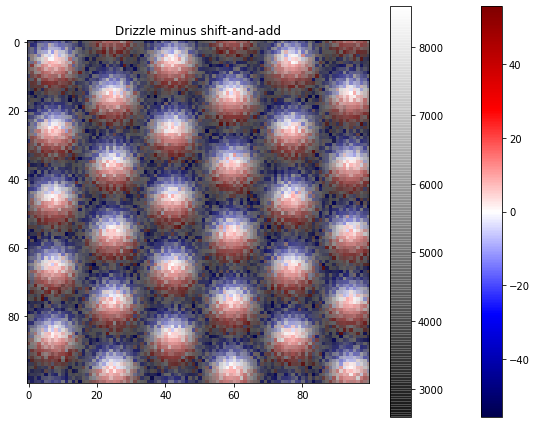

In [199]:
# drizzle parameters
p = 0.5
n = 1

ims,shifts = create_lattice_images(seed_input=2020,size=[120,120],sigma=5,d=20)
ims,shifts = add_noise(ims,shifts,seed_input=2020,
                       sigm_shift=0.5,sigm_noi_before_blur = 250.,sigm_noi_after_blur = 250.,sigm_blur = 2.)

drizzled_im = drizzle(ims,shifts,p,n)
mean_im = drizzle(ims,shifts,1,n)

#cut off borders
mean = mean_im[10:-10,10:-10]
drizzled = drizzled_im[10:-10,10:-10]

img = drizzled - mean
mima = max(-np.min(img),np.max(img))
plt.figure(figsize=(8,6))
plt.imshow(img,cmap='seismic',vmin=-mima,vmax=mima,interpolation='none')
plt.title("Drizzle minus shift-and-add")
plt.colorbar()
plt.imshow(mean,cmap='gray',alpha = 0.7,interpolation='none')
plt.colorbar()
plt.tight_layout()
#plt.savefig(save_folder+'/Shifted_drizzle_minus_shift_and_add_inverted.pdf', interpolation='none')
plt.show()

# Average shift versus peak of cross correlation

In [35]:
n=1
p=0.5

N = 50 #number of runs

#argmaxs = []
#av_shifts = []

for i in range(N):
    ims,shifts = create_lattice_images(seed_input=i,size=[50,50])
    drizzled_im = drizzle(ims,shifts,p,n)
    mean_im = drizzle(ims,shifts,1,n)

    #cut borders to prevent from border effects
    mean = mean_im[10:-10,10:-10]
    drizzled = drizzled_im[10:-10,10:-10]

    argmax = correlate(drizzled,mean)
    av_shift = meansh(shifts)
    
    argmaxs.append(argmax)
    av_shifts.append(av_shift)


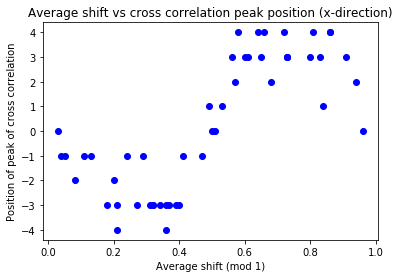

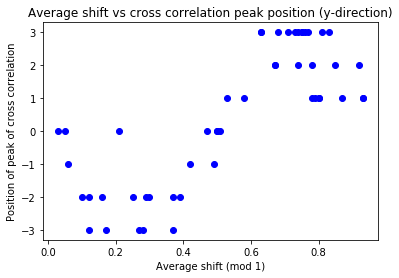

In [36]:
for i,av in enumerate(av_shifts):
    plt.plot(av[0],argmaxs[i][1]-15,"o",color="blue")
plt.title("Average shift vs cross correlation peak position (x-direction)")
plt.xlabel("Average shift (mod 1)")
plt.ylabel("Position of peak of cross correlation")
#plt.savefig(save_folder+'/av shift vs cross corr x-dir -- new average.pdf', interpolation='none')
plt.show()


for i,av in enumerate(av_shifts):
    plt.plot(av[1],argmaxs[i][0]-15,"o",color="blue")
plt.title("Average shift vs cross correlation peak position (y-direction)")
plt.xlabel("Average shift (mod 1)")
plt.ylabel("Position of peak of cross correlation")
#plt.savefig(save_folder+'/av shift vs cross corr y-dir -- new average.pdf', interpolation='none')
plt.show()

# Center value of cross correlation for a range of pixfracs

In [200]:
n = 1 #scale factor 1/n
p_s = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] #pixfracs

N = 10 #number of input images to calculate

maxs = [] #Maximum values of the cross correlations

imss = []
shiftss = []

for i in range(N):
    print("Image "+str(i))
    maxs.append([])

    ims,shifts = create_lattice_images(seed_input=i,sigma=5,d=20,size=[120,120],sigma_shifts=3)
    ims,shifts = add_noise(ims,shifts,seed_input=i)
    shifts = center_shifts(shifts)
    
    imss.append(ims)
    shiftss.append(shifts)
    ims = imss[i]
    shifts = shiftss[i]
    
    mean_im = drizzle(ims,shifts,1,n)
    mean = mean_im[10:-10,10:-10] #cutt off borders

    for p in p_s:
        print("Pixfrac "+str(p))
        drizzled_im = drizzle(ims,shifts,p,n)
        drizzled = drizzled_im[10:-10,10:-10]
        corr = ndimage.correlate(mean,drizzled-mean)
        maxs[i].append(corr[50][50])

Image 0
Pixfrac 0.1
Pixfrac 0.2
Pixfrac 0.3
Pixfrac 0.4
Pixfrac 0.5
Pixfrac 0.6
Pixfrac 0.7
Pixfrac 0.8
Pixfrac 0.9
Pixfrac 1
Image 1
Pixfrac 0.1
Pixfrac 0.2
Pixfrac 0.3
Pixfrac 0.4
Pixfrac 0.5
Pixfrac 0.6
Pixfrac 0.7
Pixfrac 0.8
Pixfrac 0.9
Pixfrac 1
Image 2
Pixfrac 0.1
Pixfrac 0.2
Pixfrac 0.3
Pixfrac 0.4
Pixfrac 0.5
Pixfrac 0.6
Pixfrac 0.7
Pixfrac 0.8
Pixfrac 0.9
Pixfrac 1
Image 3
Pixfrac 0.1
Pixfrac 0.2
Pixfrac 0.3
Pixfrac 0.4
Pixfrac 0.5
Pixfrac 0.6
Pixfrac 0.7
Pixfrac 0.8
Pixfrac 0.9
Pixfrac 1
Image 4
Pixfrac 0.1
Pixfrac 0.2
Pixfrac 0.3
Pixfrac 0.4
Pixfrac 0.5
Pixfrac 0.6
Pixfrac 0.7
Pixfrac 0.8
Pixfrac 0.9
Pixfrac 1
Image 5
Pixfrac 0.1
Pixfrac 0.2
Pixfrac 0.3
Pixfrac 0.4
Pixfrac 0.5
Pixfrac 0.6
Pixfrac 0.7
Pixfrac 0.8
Pixfrac 0.9
Pixfrac 1
Image 6
Pixfrac 0.1
Pixfrac 0.2
Pixfrac 0.3
Pixfrac 0.4
Pixfrac 0.5
Pixfrac 0.6
Pixfrac 0.7
Pixfrac 0.8
Pixfrac 0.9
Pixfrac 1
Image 7
Pixfrac 0.1
Pixfrac 0.2
Pixfrac 0.3
Pixfrac 0.4
Pixfrac 0.5
Pixfrac 0.6
Pixfrac 0.7
Pixfrac 0.8
Pixfrac 0.9
Pi

In [201]:
maxs

[[120849414.29473996,
  119698697.32825106,
  120327868.49406639,
  112991687.21030338,
  100630943.59162045,
  89247543.84838714,
  76041964.1969385,
  55868268.575526655,
  31259516.971195027,
  0.0],
 [156166539.9218127,
  151112043.25036803,
  148528296.82716912,
  141254833.4042751,
  130894506.99043289,
  113772414.63296923,
  92681728.23607516,
  62454641.98638551,
  32441414.89041456,
  0.0],
 [142048156.29059744,
  144028261.41748607,
  138281484.08613795,
  129170628.09964702,
  118657459.55903746,
  104138728.52175485,
  86599091.32423934,
  63331827.27904713,
  31750416.44356325,
  0.0],
 [154527096.85583276,
  145699079.10888347,
  136798435.66875482,
  127743145.91988079,
  118134340.82296136,
  105451135.62059298,
  87081341.1576246,
  63723855.19153169,
  33499188.593555674,
  0.0],
 [128986212.700099,
  131816678.32634549,
  130931483.57975379,
  122228362.52170064,
  112129371.72333594,
  96942267.15401138,
  80107000.32442334,
  60191810.61603392,
  32458491.28920346

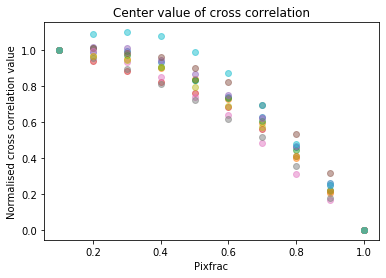

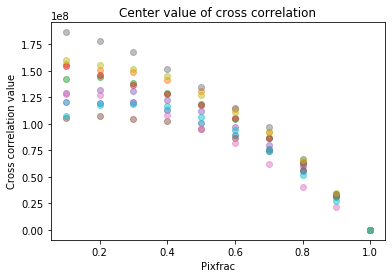

In [203]:
for mx in maxs[:]:
    plt.plot(p_s,mx/mx[0],"o",alpha=0.5)
plt.title("Center value of cross correlation")
plt.xlabel("Pixfrac")
plt.ylabel("Normalised cross correlation value")
plt.savefig(save_folder+'/Artificial_moire_images_center_of_crosscorrelation_normalised.pdf', interpolation='none')
plt.show()


for mx in maxs[:]:
    plt.plot(p_s,mx,"o",alpha=0.5)
plt.title("Center value of cross correlation")
plt.xlabel("Pixfrac")
plt.ylabel("Cross correlation value")
plt.savefig(save_folder+'/Artificial_moire_images_center_of_crosscorrelation.pdf', interpolation='none')
plt.show()